In [239]:
import os
import random
from tqdm import tqdm
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from nnAudio import Spectrogram
from scipy.io import wavfile
import matplotlib.pyplot as plt
from audio_tools import preprocessing

In [19]:
data_dir = "data"
processed_dir = "compressed"
_files = os.listdir(data_dir)
_files.remove(".DS_Store")

In [41]:
for f in _files:
    audio_list = os.listdir(os.path.join(data_dir, f))
    for a in tqdm(audio_list):
        if a [-4:] == ".wav":
            source_full = os.path.join(data_dir, f, a)
            target_full = os.path.join(processed_dir, a[:-4]+".mp3")
            preprocessing.normalize(source_full, target_full, bitrate=320000)

100%|██████████| 1921/1921 [04:09<00:00,  7.71it/s]


In [44]:
low_res = "low"

audio_list = os.listdir(os.path.join(processed_dir))
for a in tqdm(audio_list):
    if a [-4:] == ".mp3":
        source_full = os.path.join(processed_dir, a)
        target_full = os.path.join(low_res, a[:-4]+".mp3")
        preprocessing.normalize(source_full, target_full, bitrate=32000)

100%|██████████| 27021/27021 [1:32:23<00:00,  4.87it/s]      


In [2]:
test_file = os.listdir("low")[0]

In [3]:
waveform, sample_rate = torchaudio.load(os.path.join("low", test_file))

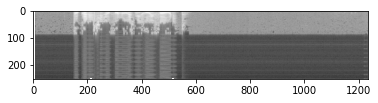

In [282]:
spectogram = torchaudio.transforms.Spectrogram(500)(waveform)
plt.figure()
plt.imshow(spectogram.log2()[0,:,:].numpy(), cmap="gray")

In [5]:
print("Min of waveform: {}\nMax of waveform:{}\nMean of waveform: {}".format(waveform.min(), waveform.max(), waveform.mean()))

Min of waveform: -0.6619201302528381
Max of waveform:0.44043031334877014
Mean of waveform: -1.8614398868521675e-05


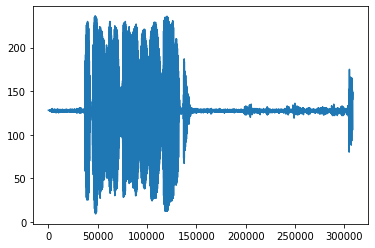

In [6]:
transformed = torchaudio.transforms.MuLawEncoding()(waveform)

plt.figure()
plt.plot(transformed[0,:].numpy())

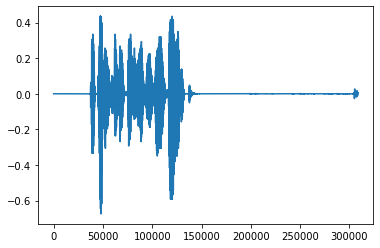

In [7]:
reconstructed = torchaudio.transforms.MuLawDecoding()(transformed)

plt.figure()
plt.plot(reconstructed[0,:].numpy())

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.spec_layer = Spectrogram.STFT(
            n_fft=2048, freq_bins=None, hop_length=512, window="hann",
            freq_scale="no", center=True, pad_mode="reflect", fmin=50,
            fmax=6000, sr=48000, trainable=False, output_format="Magnitude", device="cpu"
        )
        self.n_bins = freq_bins
    
        self.CNN_freq_kernel_size = (128, 1)
        self.CNN_freq_kernel_stride=(2, 1)
        k_out = 128
        k2_out = 256
        self.CNN_freq = nn.Conv2d(1, k_out, kernel_size=self.CNN_freq_kernel_size, stride=self.CNN_freq_kernel_stride)
        self.CNN_time = nn.Conv2d(k_out, k2_out, kernel_size=(1, regions))
        
    def forward(self, x):
        z = self.spec_layer(x)
        z = torch.log(z+epsilon)
        z2 = torch.relu(self.CNN_freq(z.unsqueeze(1)))
        z3 = torch.relu(self.CNN_time(z2))
        y = self.linear(torch.relu(torch.flatten(z3, 1)))
        return torch.sigmoid(y)

In [93]:
net = Net()

STFT kernels created, time used = 0.1056 seconds


NameError: name 'freq_bins' is not defined

In [111]:
len(waveform[0])

308736

In [112]:
spectogram.size()

torch.Size([1, 201, 1544])

In [118]:
waveform[0][-1]

tensor(-0.0062)

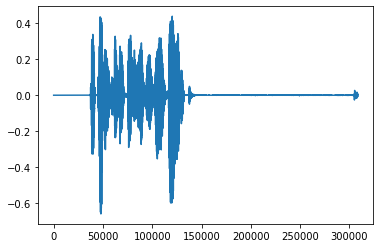

In [126]:
plt.figure()
plt.plot(waveform.t().numpy())

In [122]:
m1 = nn.Conv1d(201, 100, 3,stride=2)
output = m1(spectogram)
p1 = nn.AvgPool1d(2)
output = p1(output)
m2 = nn.Conv1d(100, 100, 3,stride=2)
output = m2(output)
p2 = nn.AvgPool1d(2)
output = p2(output)
output = output.transpose(1, 2).transpose(0, 1)
n1 = nn.Linear(100, 50)
output = n1(output)

In [191]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(201, 100, 1, stride=2)
        self.pool1 = nn.AvgPool1d(2)
        self.conv2 = nn.Conv1d(100, 50, 3, stride=2)
        self.pool2 = nn.AvgPool1d(2)
        self.fc1 = nn.Linear(50, 512)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(512, 200)
        self.dropout2 = nn.Dropout2d(0.5)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = x.transpose(1, 2).transpose(0, 1)
        x = F.tanh(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

my_nn = Net()
print(my_nn)

Net(
  (conv1): Conv1d(201, 100, kernel_size=(1,), stride=(2,))
  (pool1): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (conv2): Conv1d(100, 50, kernel_size=(3,), stride=(2,))
  (pool2): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
  (fc1): Linear(in_features=50, out_features=512, bias=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=512, out_features=200, bias=True)
  (dropout2): Dropout2d(p=0.5, inplace=False)
)


In [179]:
result = my_nn(x)
print (result)

tensor([[[ 0.0000,  0.0000, -0.0000,  ...,  0.0000,  0.0000,  0.0000]],

        [[ 0.0634,  0.0094, -0.1133,  ...,  0.0072,  0.1219,  0.1479]],

        [[ 0.0635,  0.0094, -0.1133,  ...,  0.0072,  0.1219,  0.1479]],

        ...,

        [[ 0.0635,  0.0096, -0.1132,  ...,  0.0073,  0.1220,  0.1479]],

        [[ 0.0645,  0.0108, -0.1131,  ...,  0.0060,  0.1209,  0.1473]],

        [[ 0.1303,  0.1121, -0.0922,  ...,  0.0472,  0.0857,  0.0570]]],
       grad_fn=<MulBackward0>)


In [139]:
device = torch.device("cpu")

In [259]:
file_y = os.listdir("compressed")[0]
file_x = os.listdir("low")[0]
waveform_y, sample_rate = torchaudio.load(os.path.join("low", file_y))
waveform_x, sample_rate = torchaudio.load(os.path.join("low", file_x))
y = torchaudio.transforms.MelScale(n_mels=128, sample_rate=48000)(waveform_y)
x = torchaudio.transforms.MelScale(n_mels=128, sample_rate=48000)(waveform_x)

In [272]:
print("Min of waveform: {}\nMax of waveform:{}\nMean of waveform: {}".format(y.min(), y.max(), y.mean()))

Min of waveform: -0.0
Max of waveform:-0.0
Mean of waveform: 0.0


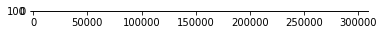

In [271]:
plt.figure()
plt.imshow(x, cmap="gray")

In [163]:
learning_rate = 1e-6
loss_fn = torch.nn.MSELoss()
for t in range(500):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    y_pred = my_nn(x)

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y)
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    my_nn.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in my_nn.parameters():
            param -= learning_rate * param.grad

99 7.689265156099848e+20
199 7.687770523973515e+20
299 9.845585139247633e+20
399 7.204489951647829e+20
499 8.882459396687014e+20


In [164]:
result = my_nn(x)

In [180]:
result.size()

torch.Size([96, 1, 200])

In [238]:
y.size()

torch.Size([1, 5001, 62])

In [188]:
len(x[0].T)

1544

In [194]:
m1 = nn.Linear(201, 200)
output = m1(x[0].T[0].unsqueeze(0))
m2 = nn.Linear(200, 200)


In [249]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.fc1 = nn.Linear(10001, 5000)
        self.dropout1 = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(5000, 5000)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc3 = nn.Linear(5000, 10001)
        self.dropout3 = nn.Dropout2d(0.25)
    
    def forward(self, x):
        x = F.tanh(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = F.tanh(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = F.tanh(x)
        x = self.fc3(x)
        x = self.dropout3(x)
        return x

audionet = AudioNet()
print(audionet)

AudioNet(
  (fc1): Linear(in_features=10001, out_features=5000, bias=True)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=5000, out_features=5000, bias=True)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (fc3): Linear(in_features=5000, out_features=10001, bias=True)
  (dropout3): Dropout2d(p=0.25, inplace=False)
)


In [251]:
file_y = os.listdir("compressed")[0]
file_x = os.listdir("low")[0]
waveform_y, sample_rate = torchaudio.load(os.path.join("low", file_y))
waveform_x, sample_rate = torchaudio.load(os.path.join("low", file_x))
y = torchaudio.transforms.Spectrogram(20000)(waveform_y)
x = torchaudio.transforms.Spectrogram(20000)(waveform_x)


learning_rate = 1e-6
loss_fn = torch.nn.MSELoss()
for t in range(1000):
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    ind = random.randint(0,30)
    y_pred = audionet(x[0].T[ind].unsqueeze(0))

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y[0].T[ind].unsqueeze(0))
    if t % 100 == 99:
        print(t, loss.item())

    # Zero the gradients before running the backward pass.
    audionet.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in audionet.parameters():
            param -= learning_rate * param.grad

99 0.00013660949480254203
199 0.00014762720093131065
299 0.0001682726724538952
399 0.10041274130344391
499 2.591531753540039
599 0.0001651124912314117
699 0.00013609090819954872
799 0.00014288075908552855
899 207440.609375
999 0.00013862657942809165


In [200]:
import numpy as np

In [252]:
gen_data = []
for t in range(30):
    y_pred = audionet(x[0].T[t].unsqueeze(0))
    gen_data.append(y_pred.detach().numpy())

In [216]:
np.array(gen_data)

array([[[ 0.1323791 ,  0.12846693,  0.10530932, ..., -0.0096742 ,
         -0.        , -0.        ]],

       [[ 0.        ,  0.        ,  0.09175991, ...,  0.        ,
         -0.18385105, -0.        ]],

       [[ 0.12167166,  0.        ,  0.        , ..., -0.        ,
         -0.        , -0.08042313]],

       ...,

       [[ 0.        ,  0.1542942 ,  0.06198515, ..., -0.        ,
         -0.25531012, -0.        ]],

       [[ 0.        ,  0.        ,  0.11166327, ...,  0.08022741,
         -0.        , -0.        ]],

       [[ 0.        ,  0.        ,  0.10199805, ...,  0.        ,
         -0.        , -0.        ]]], dtype=float32)

In [208]:
from scipy.io.wavfile import write

In [253]:
write("example.wav", 48000, np.array(gen_data))

In [254]:
gen_data = []
for t in range(30):
    y_pred = y[0].T[t].unsqueeze(0)
    gen_data.append(y_pred.detach().numpy())

In [255]:
write("example_y.wav", 48000, np.array(gen_data))

In [226]:
len(waveform_x[0])

308736

In [247]:
file_x

'com_04310_00504940818.mp3'

In [290]:
import librosa
import librosa.display

In [291]:
y, sr = librosa.load(os.path.join("low", file_x))

/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


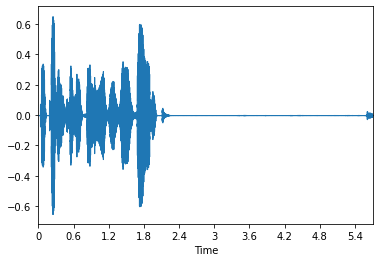

In [292]:
whale_song, _ = librosa.effects.trim(y)
librosa.display.waveplot(whale_song, sr=sr);

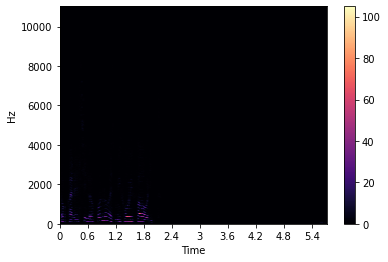

In [294]:
hop_length = 512
n_fft = 2048
D = np.abs(librosa.stft(whale_song, n_fft=n_fft,  hop_length=hop_length))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear');
plt.colorbar();

/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


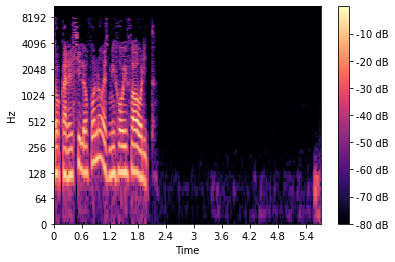

In [295]:
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [306]:
reconstructed_audio = librosa.istft(D)

In [307]:
librosa.output.write_wav('test1.wav', reconstructed_audio, 48000)

AttributeError: module 'librosa' has no attribute 'output'

In [308]:
import soundfile as sf

In [311]:
sf.write('test1.wav', reconstructed_audio, 22000)

In [314]:
D.shape

(1025, 247)

In [444]:
class AudioNet(nn.Module):
    def __init__(self):
        super(AudioNet, self).__init__()
        self.fc1 = nn.Linear(247, 494)
        self.fc2 = nn.Linear(494, 988)
        self.fc3 = nn.Linear(988, 494)
        self.fc4 = nn.Linear(494, 247)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        return x

audionet = AudioNet()
print(audionet)

AudioNet(
  (fc1): Linear(in_features=247, out_features=494, bias=True)
  (fc2): Linear(in_features=494, out_features=988, bias=True)
  (fc3): Linear(in_features=988, out_features=494, bias=True)
  (fc4): Linear(in_features=494, out_features=247, bias=True)
)


In [446]:
hop_length = 512
n_fft = 2048

file_y = os.listdir("compressed")[0]
file_x = os.listdir("low")[0]
y, sr = librosa.load(os.path.join("compressed", file_y))
x, sr = librosa.load(os.path.join("low", file_x))
trimmed_y, _ = librosa.effects.trim(y)
trimmed_x, _ = librosa.effects.trim(x)
y = np.abs(librosa.stft(trimmed_y, n_fft=n_fft,  hop_length=hop_length))
x = np.abs(librosa.stft(trimmed_x, n_fft=n_fft,  hop_length=hop_length))
y = torch.from_numpy(y)
x = torch.from_numpy(x)
moving_avg = []
learning_rate = 1e-6
loss_fn = torch.nn.MSELoss()
pbar = tqdm(range(1000000))
loss_val = []
for t in pbar:
    # Forward pass: compute predicted y by passing x to the model. Module objects
    # override the __call__ operator so you can call them like functions. When
    # doing so you pass a Tensor of input data to the Module and it produces
    # a Tensor of output data.
    ind = random.randint(0,246)
    y_pred = audionet(x[ind].unsqueeze(0))

    # Compute and print loss. We pass Tensors containing the predicted and true
    # values of y, and the loss function returns a Tensor containing the
    # loss.
    loss = loss_fn(y_pred, y[ind].unsqueeze(0))
    loss_val.append(loss.item())
    loss_avg = sum(loss_val)/len(loss_val)
    if len(loss_val) > 100:
        loss_val.pop(0)
        moving_avg.append(loss_avg)
    pbar.set_postfix({'Loss': loss_avg})

    # Zero the gradients before running the backward pass.
    audionet.zero_grad()

    # Backward pass: compute gradient of the loss with respect to all the learnable
    # parameters of the model. Internally, the parameters of each Module are stored
    # in Tensors with requires_grad=True, so this call will compute gradients for
    # all learnable parameters in the model.
    loss.backward()

    # Update the weights using gradient descent. Each parameter is a Tensor, so
    # we can access its gradients like we did before.
    with torch.no_grad():
        for param in audionet.parameters():
            param -= learning_rate * param.grad

/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
100%|██████████| 1000000/1000000 [1:32:37<00:00, 179.93it/s, Loss=5.24]


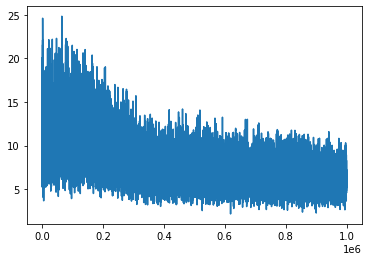

In [450]:
plt.plot(moving_avg)

In [451]:
gen_data = []
for t in range(1025):
    y_pred = audionet(x[t].unsqueeze(0))
    gen_data.append(y_pred.detach().numpy()[0])

In [429]:
gen_data_2 = []
for t in range(1025):
    y_pred = y[t].unsqueeze(0)
    gen_data_2.append(y_pred.detach().numpy()[0])

/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/tryu/Programs/Audio-Upscaling/venv/lib/python3.8/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linscaley' parameter of __init__() has been renamed 'linscale' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


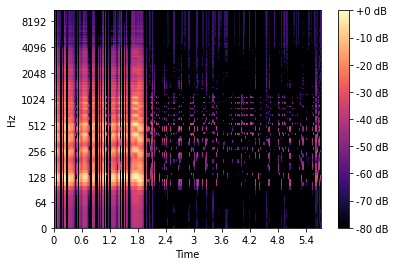

In [452]:
D = np.array(gen_data)
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

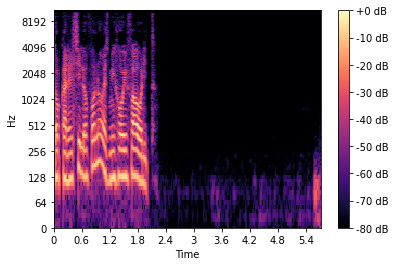

In [431]:
D = np.array(gen_data_2)
DB = librosa.amplitude_to_db(D, ref=np.max)
librosa.display.specshow(DB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='log');
plt.colorbar(format='%+2.0f dB');

In [453]:
D.shape

(1025, 247)

In [454]:
reconstructed_audio = librosa.istft(D)

In [455]:
sf.write('test1.wav', reconstructed_audio, sr)